In [45]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

In [46]:
class Node:
    def __init__(self, id, type, parents, weights, neuralNetwork):
        self.id = id
        self.type = type
        self.parents = parents
        self.weights = weights
        self.inputs = {}
        self.output = 0
        self.children = []
        self.neuralNetwork = neuralNetwork
        print(f"{self.type} node {self.id} created with weights {self.weights}.")
    def setValue(self, setterID, value):
        self.inputs[setterID] = value
        if len(self.inputs) == len(self.weights):
            self.ActivationFunction()

    def AddChildren(self, children):
        self.children = children
        for child in children:
            print(f"{child.id} added as child of {self.id}.")
        if self.type == "Hidden" or self.type == "Input":
            if len(children) == 0:
                raise f"{self.type} node added 0 children."

    def ActivationFunction(self):
        # print(f"Activation Function called on {self.id}")
        phi = 0
        if self.type == "Input":
            self.result = self.inputs["neuralNetwork"]
        else:
            if len(self.parents) != len(self.weights):
                raise f"Weights, parents mismatch: weights = {self.weights}, parents: {self.parents}"
            for parent in self.parents:
                phi += self.weights[parent.id] * self.inputs[parent.id]                     # \sum w_i * x_i
            phi += 1                                                                        # fixed bias 1
            localResult = 1 / (1 - (np.e ** phi))
            self.result = localResult
        if self.children != None:
            for child in self.children:
                child.setValue(setterID=self.id, value=self.result)
        else:
            print(f"Final Output: {self.result}")
        if self.neuralNetwork != None:
            if self.type == "Output":
                self.neuralNetwork.output = self.result
        return self.result
    
    def UpdateWeights(self, previousDelta, eta, desiredOutput):
        if type(previousDelta) != type({"lol" : 0.1}):
            raise f"Unexpected datatype {type(previousDelta)}, expected dict."
        if type(eta) != float and type(eta) != int:
            raise f"Unexpected datatype {type(eta)}, expected int/float."
        if type(desiredOutput) != int and type(desiredOutput) != float:
            raise f"Unexpected datatype {type(desiredOutput)}, expected int/float."
        if (self.type == "Input"):
            pass
        elif (self.type == "Hidden"):
            delta = 0
            childWeights = self.getChildrenWeights()
            for key in childWeights.keys():
                delta += (previousDelta[key] * childWeights[key])
            delta *= (self.result * (1 - self.result))
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] - (delta * eta * self.inputs[key])
            return delta 
        elif (self.type == "Output"):
            delta = self.result * (1 - self.result) * (desiredOutput - self.result)
            for key in self.weights.keys():
                self.weights[key] = self.weights[key] - (eta * delta * self.inputs[key])
            return delta
        else:
            raise f"Invalid type {self.type}, expected Input/Hidden/Output"

    
    def getChildrenWeights(self):
        weight = {}
        if len(self.children) != 0:
            for child in self.children:
                weight[child.id] = child.weights[self.id]
        return weight
                
    

In [47]:
class NeuralNetwork:
    def __init__(self, inputCount, hiddenlayerWidth, hiddenLayerDepth, outputCount):
        if type(hiddenLayerDepth) != int or type(hiddenlayerWidth) != int or type(outputCount) != int or type(inputCount) != int:
            raise "All inputs are supposed to be integer."
        self.id = "neuralNetwork"
        self.output = 0
        currentLayer = []
        parentLayer = []
        layerCounter = 0
        for nodeNumber in range(1, inputCount + 1):
            currentLayer.append(Node(id=f"({layerCounter},{nodeNumber})", type="Input", parents=[self], weights={self.id: 1}, neuralNetwork=self))
        self.networkHead = currentLayer
        for hiddenLayerNumber in range(1, hiddenLayerDepth + 1):
            parentLayer = currentLayer
            currentLayer = []
            for nodeNumber in range(1, hiddenlayerWidth + 1):
                weights = {}
                for parent in parentLayer:
                    weights[parent.id] = 0.4
                node = Node(id=f"({hiddenLayerNumber}, {nodeNumber})", type="Hidden", parents=parentLayer, weights=weights, neuralNetwork=self)
                currentLayer.append(node)
            for parent in parentLayer:
                parent.AddChildren(currentLayer)
        parentLayer = currentLayer
        currentLayer = []
        layerCounter += (hiddenLayerDepth + 1)
        for outputCount in range(1, outputCount + 1):
            weights = {}
            for parent in parentLayer:
                weights[parent.id] = 0.5
            node = Node(id=f"({layerCounter}, {outputCount})", type="Output", parents=parentLayer, neuralNetwork=self, weights=weights)
            currentLayer.append(node)
        for parent in parentLayer:
            parent.AddChildren(children=currentLayer)
        self.outputLayer = currentLayer
    
    def GetError(self, inputs, outputs):
        if len(inputs) != len(outputs):
            raise f"Input output count mismatch. Input: {len(inputs)} Output: {len(outputs)}."
        nnOutput = []
        error = []
        for input in inputs:
            self.networkHead[0].setValue(setterID = self.id, value = input[0])
            self.networkHead[1].setValue(setterID = self.id, value = input[1])
            nnOutput.append(self.output)
        for i in range(0, len(outputs)):
            error.append((nnOutput[i] - outputs[i]) * (nnOutput[i] - outputs[i]))
        return error

    def BackTrack(self, learningRate, desiredOutput):
        if len(self.outputLayer) == 0:
            raise "No output layer to backtrack from."
        currentLayer = self.outputLayer
        previousDelta = {}
        deltaLayer = {}
        while type(currentLayer[0]) != type(self):
            for node in currentLayer:
                delta = node.UpdateWeights(previousDelta=previousDelta, eta = learningRate, desiredOutput = desiredOutput)
                deltaLayer[node.id] = delta
            # print(deltaLayer)
            previousDelta = deepcopy(deltaLayer)
            deltaLayer.clear()
            currentLayer = currentLayer[0].parents

    def FlushNeuralNetwork(self):
        currentLayer = self.networkHead
        while len(currentLayer) != 0:
            for node in currentLayer:
                node.inputs.clear()
            currentLayer = currentLayer[0].children

    def Train(self, epoches, inputs, outputs, learningRate):
        errors = []
        for i in range(1, epoches + 1):
            temporaryErrors = 0
            for j in range(len(inputs)):
                self.networkHead[0].setValue(setterID=self.id, value=inputs[j][0])
                self.networkHead[1].setValue(setterID=self.id, value=inputs[j][1])
                temporaryErrors += ((self.output - outputs[j]) * (self.output - outputs[j]))
                self.BackTrack(learningRate=learningRate, desiredOutput=outputs[j])
                self.FlushNeuralNetwork()
            temporaryErrors /= len(outputs)
            errors.append(temporaryErrors)
        return errors



In [50]:
nn = NeuralNetwork(inputCount=2, hiddenlayerWidth=2, hiddenLayerDepth=1, outputCount=1)
nn.outputLayer[0].weights
nn.GetError(inputs=[[0, 0], [1, 0], [0, 1], [1, 1]], outputs=[0, 1, 1, 0])
nn.FlushNeuralNetwork()
errors = nn.Train(epoches=10, inputs=[[0, 0], [1, 0], [0, 1], [1, 1]], outputs=[0, 1, 1, 0], learningRate= 0.2)
nn.GetError(inputs=[[0, 0], [1, 0], [0, 1], [1, 1]], outputs=[0, 1, 1, 0])

Input node (0,1) created with weights {'neuralNetwork': 1}.
Input node (0,2) created with weights {'neuralNetwork': 1}.
Hidden node (1, 1) created with weights {'(0,1)': 0.4, '(0,2)': 0.4}.
Hidden node (1, 2) created with weights {'(0,1)': 0.4, '(0,2)': 0.4}.
(1, 1) added as child of (0,1).
(1, 2) added as child of (0,1).
(1, 1) added as child of (0,2).
(1, 2) added as child of (0,2).
Output node (2, 1) created with weights {'(1, 1)': 0.5, '(1, 2)': 0.5}.
(2, 1) added as child of (1, 1).
(2, 1) added as child of (1, 2).


[0.007680316190870417,
 1.626215386944964,
 1.626089610276609,
 0.17466619708183767]

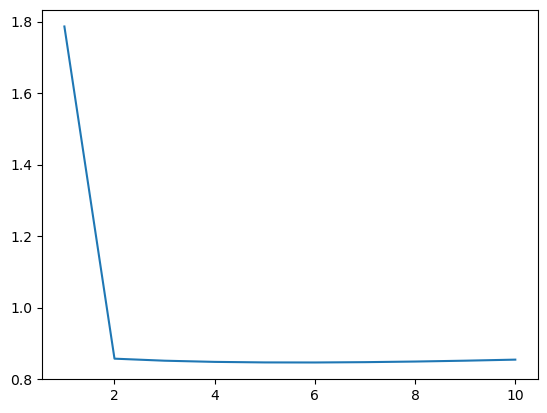

In [51]:
errors = np.array(errors)
errors
plt.plot(range(1, len(errors) +1), errors)